# Test constants

In [1]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps, init_device
from modules.data import WeatherBenchDatasetXarrayHealpix, WeatherBenchDatasetIterative
from modules.healpix_models import UNetSphericalHealpix
from modules.test import create_iterative_predictions_healpix, compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

train_years = ('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
lead_time = 6
out_features = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
gpu = [0, 1]
num_workers = 10
pin_memory = True
batch_size = 100

In [2]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential/*.nc', combine='by_coords').sel(level=500).rename({'z':'z500'})
t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords').rename({'t':'t850'})
rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords')

z500 = z500.isel(time=slice(7, None))
t850 = t850.isel(time=slice(7, None))

constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg.nc').rename({'orography' :'orog'})
temp = xr.DataArray(np.zeros(z500.dims['time']), coords=[('time', z500.time.values)])
constants, _ = xr.broadcast(constants, temp)

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']

predictors_mean = xr.open_dataarray(datadir + 'predictors_mean.nc')
predictos_std = xr.open_dataarray(datadir + 'predictors_std.nc')
const_mean = xr.open_dataarray(input_dir + 'constants/const_mean.nc')
const_std = xr.open_dataarray(input_dir + 'constants/const_std.nc')

train_mean = xr.concat((predictors_mean, const_mean), dim='level')
train_std = xr.concat((predictors_mean, const_std), dim='level')

In [3]:
def run_simulation(ds, description, train_mean, train_std, in_features, out_features, gpu, epochs, lr, 
                 train_years, val_years, test_years):

    model_filename = model_save_path + "spherical_unet_" + description + ".h5"
    pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
    nb_timesteps = 2

    # Train and validation data
    ds_train = ds.sel(time=slice(*train_years))
    ds_valid = ds.sel(time=slice(*val_years))
    training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                     years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean, std=train_std)
    validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                       years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                       mean=train_mean, std=train_std)

    dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                          pin_memory=pin_memory)
    dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                        pin_memory=pin_memory)


    # Model
    spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                               kernel_size=3)
    spherical_unet, device = init_device(spherical_unet, gpu=gpu)

    # Train model
    train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=epochs, lr=lr, 
                                              validation_data=dl_val)
    torch.save(spherical_unet.state_dict(), model_filename)

    # Show training losses
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    del dl_train, dl_val, training_ds, validation_ds
    torch.cuda.empty_cache()

    # Testing data
    ds_test = ds.sel(time=slice(*test_years))
    testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                    years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                    mean=train_mean, std=train_std, max_lead_time=max_lead_time)

    dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

    # Compute predictions
    preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)
    preds.to_netcdf(pred_filename)
    
    
    del testing_ds, dataloader_test, spherical_unet, rmse, preds, 
    torch.cuda.empty_cache()

## 1. No constants

In [ ]:
description = "no_const"

nb_timesteps=2

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1]
ds = xr.merge([z500, t850], compat='override')

description = "no_const"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"


ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

train_mean_ = train_mean[feature_idx]
train_std_ = train_std[feature_idx]


# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean_, std=train_std_)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_)

Loading data into RAM
Loading data into RAM


In [ ]:
train_mean

In [ ]:
train_mean_

In [4]:
description = "no_const"

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1]
ds = xr.merge([z500, t850], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))

description = "no_const"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"



# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean, std=train_std)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean, std=train_std)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=[0, 1])

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=10, lr=8e-3, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean, std=train_std, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)

# Compute and save RMSE
rmse = compute_rmse_iterative_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, rmse, preds
torch.cuda.empty_cache()

del ds
torch.cuda.empty_cache()

Loading data into RAM
Loading data into RAM
Epoch:   1/ 10  - loss: 2.234  - val_loss: 69.23688  - time: 1668.309295


KeyboardInterrupt: 

## 2. All constants

In [ ]:
description = "all_const"

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 4, 5, 6]
ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')


run_simulation(ds, description, train_mean[feature_idx], train_std[feature_idx], in_features=len(feature_idx),
               out_features=out_features, gpu=gpu, epochs=10, lr=3e-8, train_years=train_years, 
               val_years=val_years, test_years=test_years)

del ds
torch.cuda.empty_cache()

# No orog

In [ ]:
description = "all_const_no_orog"

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 3, 4, 5, 6]
ds = xr.merge([z500, t850, lats, lsm, slt, rad], compat='override')

run_simulation(ds, description, train_mean[feature_idx], train_std[feature_idx], in_features=len(feature_idx),
               out_features=out_features, gpu=gpu, epochs=10, lr=3e-8, train_years=train_years, 
               val_years=val_years, test_years=test_years)

del ds
torch.cuda.empty_cache()

# No lats

In [ ]:
description = "all_const_no_lats"

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 4, 5, 6]
ds = xr.merge([z500, t850, orog, lsm, slt, rad], compat='override')

run_simulation(ds, description, train_mean[feature_idx], train_std[feature_idx], in_features=len(feature_idx),
               out_features=out_features, gpu=gpu, epochs=10, lr=3e-8, train_years=train_years, 
               val_years=val_years, test_years=test_years)

del ds
torch.cuda.empty_cache()

# No lsm

In [ ]:
description = "all_const_no_lsm"

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 5, 6]
ds = xr.merge([z500, t850, orog, lats, slt, rad], compat='override')

run_simulation(ds, description, train_mean[feature_idx], train_std[feature_idx], in_features=len(feature_idx),
               out_features=out_features, gpu=gpu, epochs=10, lr=3e-8, train_years=train_years, 
               val_years=val_years, test_years=test_years)

del ds
torch.cuda.empty_cache()

# No slt

In [ ]:
description = "all_const_no_slt"

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 4, 6]
ds = xr.merge([z500, t850, orog, lats, lsm, rad], compat='override')

run_simulation(ds, description, train_mean[feature_idx], train_std[feature_idx], in_features=len(feature_idx),
               out_features=out_features, gpu=gpu, epochs=10, lr=3e-8, train_years=train_years, 
               val_years=val_years, test_years=test_years)

del ds
torch.cuda.empty_cache()

# No rad

In [ ]:
description = "all_const_no_rad"

# z500, t850, orog, lats, lsm, slt, rad
feature_idx = [0, 1, 2, 3, 4, 5]
ds = xr.merge([z500, t850, orog, lats, lsm, slt], compat='override')

run_simulation(ds, description, train_mean[feature_idx], train_std[feature_idx], in_features=len(feature_idx),
               out_features=out_features, gpu=gpu, epochs=10, lr=3e-8, train_years=train_years, 
               val_years=val_years, test_years=test_years)

del ds
torch.cuda.empty_cache()

# Old

Epoch:   1/ 10  - loss: 0.027  - val_loss: 0.01309  - time: 1832.600410
Epoch:   2/ 10  - loss: 0.011  - val_loss: 0.01043  - time: 1813.063261
Epoch:   3/ 10  - loss: 0.008  - val_loss: 0.01033  - time: 1819.975486
Epoch:   4/ 10  - loss: 0.007  - val_loss: 0.00946  - time: 1822.454565
Epoch:   5/ 10  - loss: 0.007  - val_loss: 0.00861  - time: 1820.942428
Epoch:   6/ 10  - loss: 0.006  - val_loss: 0.00774  - time: 1822.087070
Epoch:   7/ 10  - loss: 0.006  - val_loss: 0.00628  - time: 1811.484113
Epoch:   8/ 10  - loss: 0.006  - val_loss: 0.00724  - time: 1825.306965
Epoch:   9/ 10  - loss: 0.006  - val_loss: 0.00633  - time: 1822.797037
Epoch:  10/ 10  - loss: 0.006  - val_loss: 0.00677  - time: 1825.544749


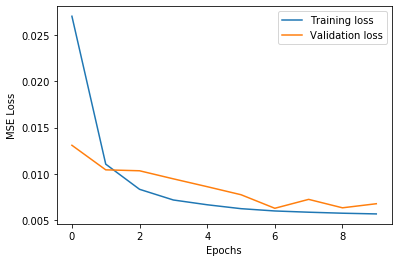

Loading data into RAM
Z500 - 0: 76.78985213740339
T850 - 0: 0.753390946149819


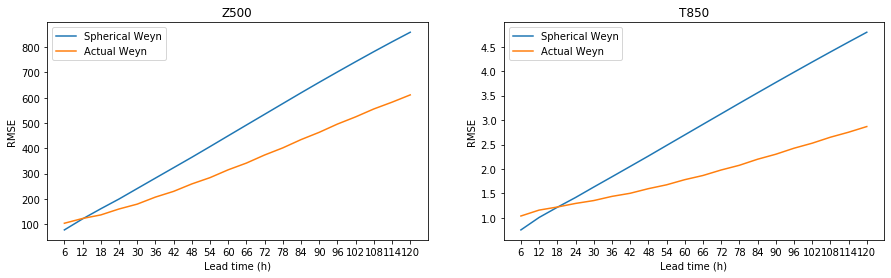

In [5]:
description = "no_const"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"

# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_train, out_features=out_features, lead_time=lead_time, 
                                                 years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                 mean=train_mean, std=train_std)
validation_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_valid, out_features=out_features, lead_time=lead_time,
                                                   years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean, std=train_std)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                      pin_memory=pin_memory)
dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, 
                    pin_memory=pin_memory)


# Model
spherical_unet = UNetSphericalHealpix1_Avg(N=nodes, in_channels=in_features, out_channels=out_features, 
                                           kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=[0, 1])

# Train model
train_loss, val_loss = train_model_2steps(spherical_unet, device, dl_train, epochs=10, lr=8e-3, 
                                          validation_data=dl_val)
torch.save(spherical_unet.state_dict(), model_filename)

# Show training losses
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

del dl_train, dl_val, training_ds, validation_ds
torch.cuda.empty_cache()

# Testing data
testing_ds = WeatherBenchDatasetXarrayHealpix(ds=ds_test, out_features=out_features, lead_time=lead_time,
                                                years=test_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                mean=train_mean, std=train_std, max_lead_time=max_lead_time)

dataloader_test = DataLoader(testing_ds, batch_size=70, shuffle=False, num_workers=num_workers)

# Compute predictions
preds = create_iterative_predictions_healpix(spherical_unet, device, dataloader_test)

# Compute and save RMSE
rmse = compute_rmse_iterative_healpix(preds, obs).load()
rmse.to_netcdf(rmse_filename)

# Show RMSE
print('Z500 - 0:', rmse.z.values[0])
print('T850 - 0:', rmse.t.values[0])
plot_rmses(rmse, rmses_weyn, lead_time)

del testing_ds, dataloader_test, spherical_unet, rmse, preds
torch.cuda.empty_cache()